In [156]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import fsolve

# longitude: x coordinate
# latitude: y coordinate

liga_coords = {
    # league: (long, lat)
    "GB1": (-1.234069,52.915917),
    "L1": (9.94846,51.525438),
    "FR1": (2.373969,46.812233),
    "IT1": (12.720198,42.673877),
    "ES1": (-3.862441,40.330021)
}

liga_config = [
    ('L1', 'ES1', 25,  False, False),
    ('ES1', 'L1', 25,   True,True), 

    ('L1', 'FR1', 15,  False,False),
    ('FR1', 'L1', 15,   True,True), 
    
    ('L1', 'GB1',25,   False,False),
    ('GB1', 'L1',25,   True,True), 
    
    ('L1', 'IT1', 25,   False,False),
    ('IT1', 'L1',25,   True,True), 
    
    ('ES1', 'FR1', 15,   False, False),
    ('FR1', 'ES1', 15,   True,True), 
    
    ('ES1', 'GB1', 35,   False, False),
    ('GB1', 'ES1',35,   True,True), 
    
    ('ES1', 'IT1', 50,   True,False),
    ('IT1', 'ES1',50,   False,False), 
    
    ('FR1', 'GB1',15,   True,False),
    ('GB1', 'FR1',15,   False,False), 

    ('FR1', 'IT1',30,   True,False),
    ('IT1', 'FR1',30,   False,False),  
    
    ('GB1', 'IT1',50,   True,False),
    ('IT1', 'GB1',50,   False,False)
]

def circle_interpolation(start_league:str,
                         end_league:str,
                         start: tuple[float,float], 
                         end: tuple[float,float], 
                         RADIUS: float,
                         year:int,
                         flip:bool=False,
                         flip_rad:bool=False) -> pd.DataFrame:


# (long, lat)

        
    def get_center():

        solutions = []
        solutions_set = set()

        def equations(vars):
            x, y = vars
            eq1 = (start[0] - x)**2 + (start[1] - y)**2 - RADIUS**2
            eq2 = (end[0] - x)**2 + (end[1] - y)**2 - RADIUS**2
            return [eq1, eq2]

   
        initial_guess = [0, 0]

        # Solve the equations
        solution = tuple(np.round(fsolve(equations, initial_guess,xtol=1e-06, maxfev=500),2))

        if not solution in solutions_set:
            solutions.append(solution)
            solutions_set.add(solution)

        return solutions[0]

    # Extracting solutions for x and y
    x_solution, y_solution = get_center()

    if flip:
        A = end[1] - start[1]
        B = -(end[0] - start[0])
        C = -A * start[0] - B * start[1]
        M = np.sqrt(A * A + B * B)
        Am = A / M
        Bm = B / M
        Cm = C / M

        D = Am * x_solution + Bm * y_solution + Cm
        x_solution = x_solution - 2 * Am * D
        y_solution = y_solution - 2 * Bm * D

    
    theta = np.linspace(0,1,100000) * 2 * np.pi
    x = x_solution + RADIUS * np.cos(theta)
    y = y_solution + RADIUS * np.sin(theta)


    xy = np.stack([x,y])

    # np.arctan2(y,x)
    start_rad = np.arctan2(end[1]-y_solution,end[0]-x_solution)
    end_rad = np.arctan2(start[1]-y_solution,start[0]-x_solution)

    if flip_rad:
        start_rad, end_rad = end_rad, start_rad

    xc = xy[0,:][(start_rad < np.arctan2(xy[1,:]-y_solution,xy[0,:]-x_solution)) & (np.arctan2(xy[1,:]-y_solution,xy[0,:]-x_solution) < end_rad)]
    yc = xy[1,:][(start_rad < np.arctan2(xy[1,:]-y_solution,xy[0,:]-x_solution)) & (np.arctan2(xy[1,:]-y_solution,xy[0,:]-x_solution) < end_rad)]
    
    if len(xc) == 0:
        return circle_interpolation(start=end,
                                    end=start,
                                    start_league=start_league,
                                    end_league=end_league,
                                    RADIUS=RADIUS,
                                    year=year,
                                    flip=flip,
                                    flip_rad=flip_rad)
    
    vec_len = round(np.sqrt((start[0] - end[0])**2 + (start[1] - end[1])**2))
    samples = np.arange(0, len(xc),len(xc)//(vec_len*1))

    xc = xc[samples]
    yc = yc[samples]

    n = len(xc)

    df = pd.DataFrame({"Year": [year]*n,
                       "From_League": [start_league]*n,
                       "To_League": [end_league]*n,
                       'Longitude': xc, 
                       'Latitude':yc,
                       "Distinction":[i for i in range(n)]})


    return df


/var/folders/3h/hhvlktwj1rzfznpk5wz5w45w0000gn/T/ipykernel_80902/1018307352.py:30: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


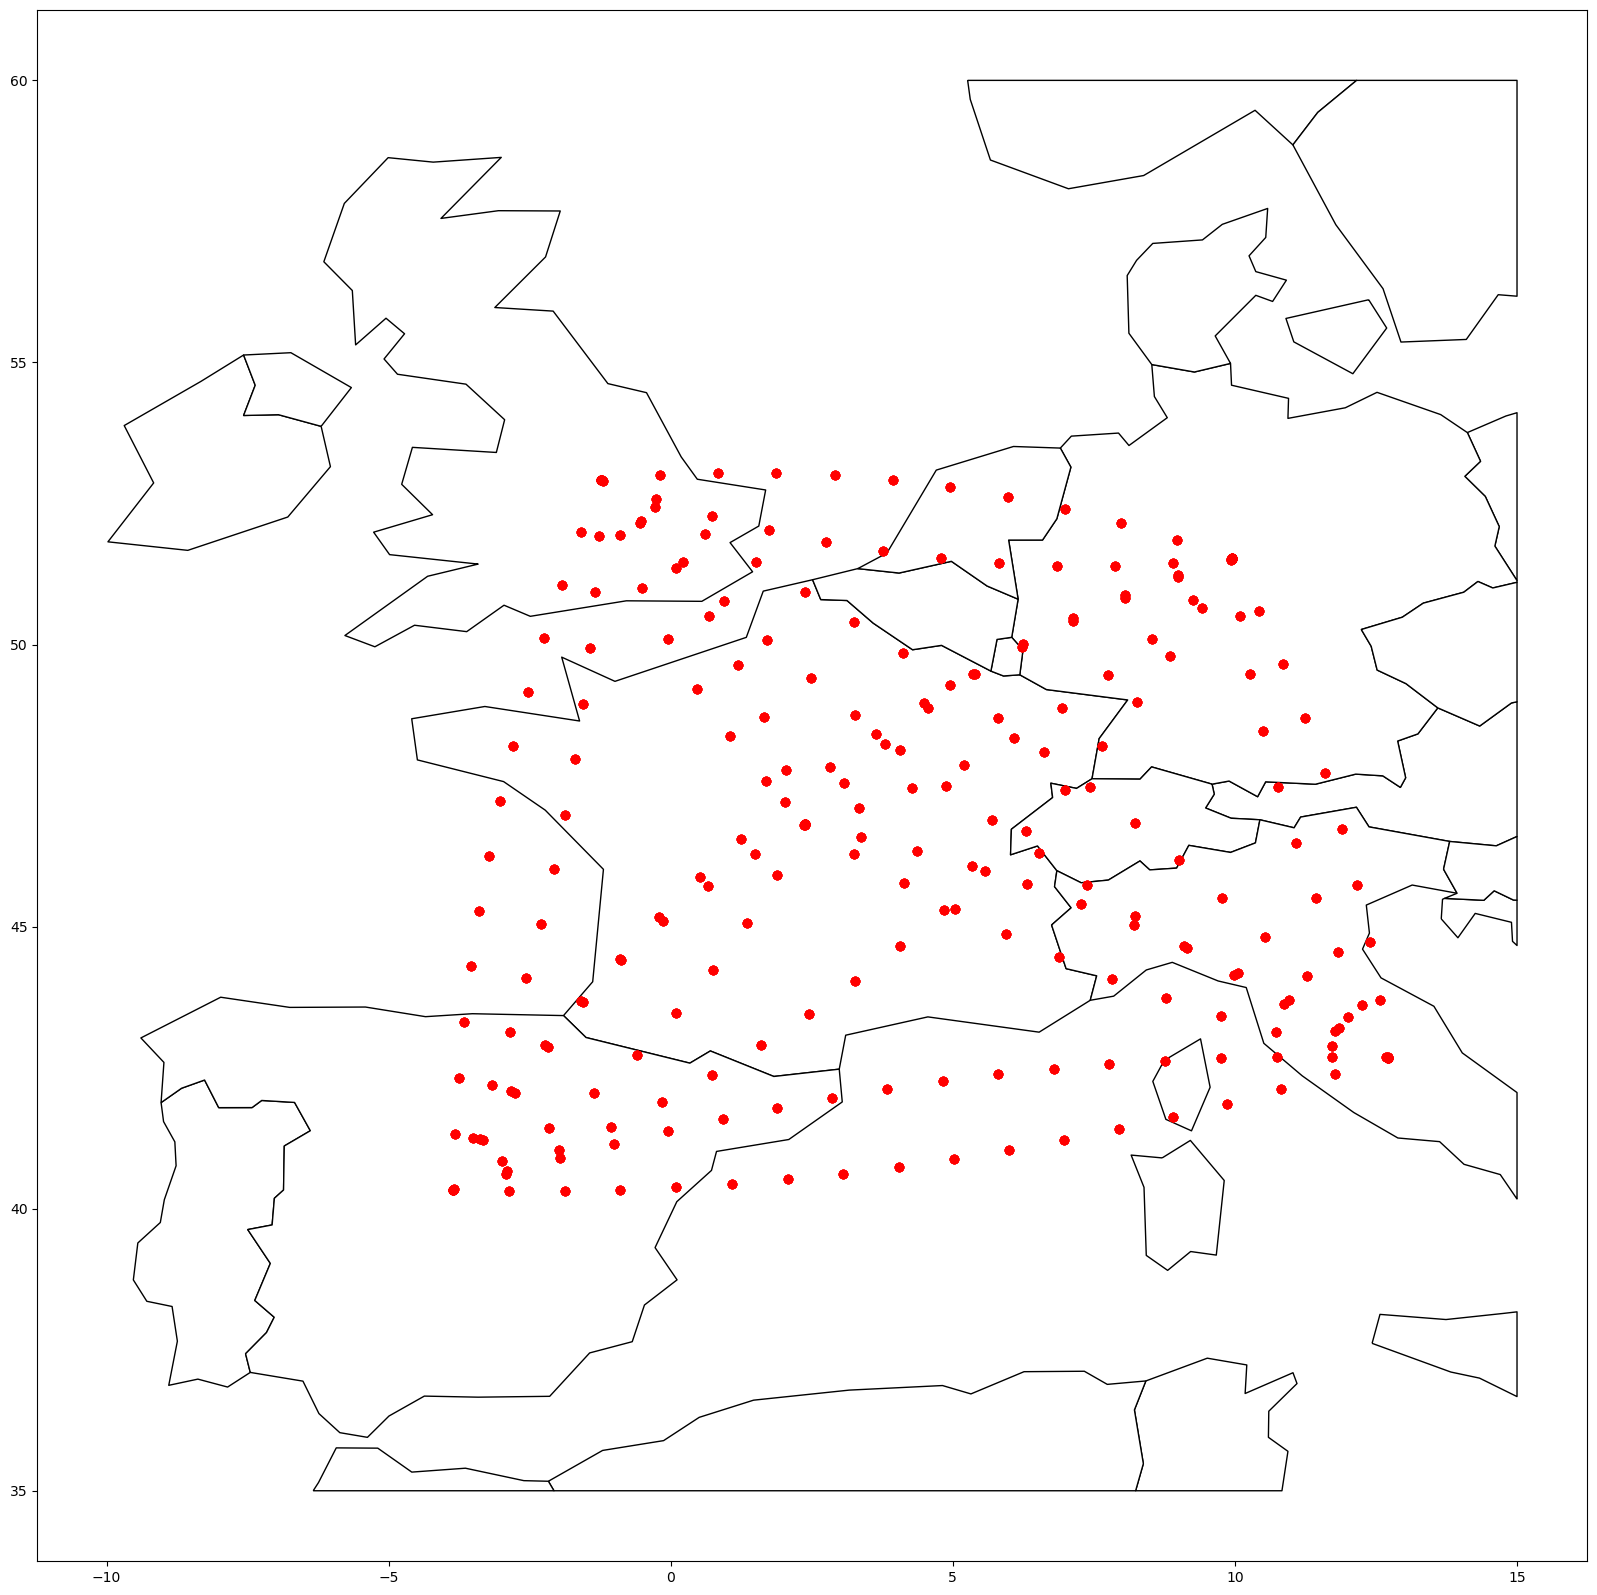

In [157]:

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

years = [2018,2019,2020,2021,2022]
dfs = []


for year in years:
    for liga1, liga2, radius, flip, flip_rad in liga_config:
        dfs.append(circle_interpolation(
        start_league=liga1, 
        end_league=liga2,
        start=liga_coords[liga1],
        end=liga_coords[liga2],
        RADIUS=radius,
        year=year, 
        flip=flip,
        flip_rad=flip_rad)
        )


df = pd.concat(dfs)


geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   


world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(20, 100))

# Create a base map
world.clip_by_rect(ymin=35, ymax=60, xmin=-10, xmax=15).plot(ax=ax, color="white", edgecolor="black")

# Plot the GeoDataFrame on the base map
gdf.plot(ax=ax, color="red")
plt.show()



In [158]:
df.to_csv("data/transfer_paths.csv", index=False)

In [152]:
df

,Year,From_League,To_League,Longitude,Latitude,Distinction
0,2018,L1,ES1,9.948460,51.525438,0
1,2018,L1,ES1,9.947531,51.527954,1
2,2018,L1,ES1,9.628928,51.420763,2
3,2018,L1,ES1,9.311796,51.309298,3
4,2018,L1,ES1,8.996190,51.193578,4
...,...,...,...,...,...,...
49,2022,IT1,GB1,-0.243106,52.414312,49
50,2022,IT1,GB1,-0.544349,52.570431,50
51,2022,IT1,GB1,-0.846645,52.724502,51
52,2022,IT1,GB1,-1.149980,52.876519,52


In [356]:
df[df["From_League"] == 'Serie A']["To_League"].unique()



array(['Bundesliga', 'LaLiga', 'Ligue 1', 'Premier League'], dtype=object)

In [ ]:
liga_config = [
    ('Bundesliga', 'LaLiga', 40,   False, False),
    ('Bundesliga', 'LaLiga', 40,   True, False), 
    ('LaLiga', 'Bundesliga', 40,   False,False),
    ('LaLiga', 'Bundesliga', 40,   True,True), 

    ('Bundesliga', 'Ligue 1', 15,   False,False),
    ('Bundesliga', 'Ligue 1', 15,   True,False), 
    ('Ligue 1', 'Bundesliga', 15,   True,False),
    ('Ligue 1', 'Bundesliga', 15,   True,True), 
    
    ('Bundesliga', 'Premier League',25,   False,False),
    ('Bundesliga', 'Premier League',25,   True,False), 
    ('Premier League', 'Bundesliga',25,   True,False),
    ('Premier League', 'Bundesliga',25,   True,True), 
    
    ('Bundesliga', 'Serie A', 25,   False,False),
    ('Bundesliga', 'Serie A', 25,   True,True), 
    ('Serie A', 'Bundesliga',25,   True,False),
    ('Serie A', 'Bundesliga',25,   True,True), 
    
    ('LaLiga', 'Ligue 1', 15,   False, False),
    ('LaLiga', 'Ligue 1', 15,   True, True), 
    ('Ligue 1', 'LaLiga', 15,   True,False),
    ('Ligue 1', 'LaLiga', 15,   True,True), 
    
    ('LaLiga', 'Premier League', 35,   False, False),
    ('LaLiga', 'Premier League', 35,  True, True),
    ('Premier League', 'LaLiga',35,   True,False),
    ('Premier League', 'LaLiga',35,   True,True), 
    
    ('LaLiga', 'Serie A', 50,   True,False),
    ('LaLiga', 'Serie A', 50,   True,True), 
    ('Serie A', 'LaLiga',50,   True,False),
    ('Serie A', 'LaLiga',50,   True,True), 
    
    ('Ligue 1', 'Premier League',15,   True,False),
    ('Ligue 1', 'Premier League',15,   True,True), 
    ('Premier League', 'Ligue 1',15,   True,False),
    ('Premier League', 'Ligue 1',15,   True,True), 

    ('Ligue 1', 'Serie A',30,   True,False),
    ('Ligue 1', 'Serie A',30,   True,True), 
    ('Serie A', 'Ligue 1',30,   True,False),
    ('Serie A', 'Ligue 1',30,   True,True),  
    
    ('Premier League', 'Serie A',50,   True,False),
    ('Premier League', 'Serie A',50,   True,True),  
    ('Serie A', 'Premier League',50,   True,False),
    ('Serie A', 'Premier League',50,   True,True)
]


In [338]:
dfs[0]

,Year,From_League,To_League,Longitude,Latitude,Distinction
0,2018,LaLiga,Bundesliga,9.840432,51.492453,0
1,2018,LaLiga,Bundesliga,9.691451,51.442175,1
2,2018,LaLiga,Bundesliga,9.542789,51.390960,2
3,2018,LaLiga,Bundesliga,9.394452,51.338812,3
4,2018,LaLiga,Bundesliga,9.246446,51.285731,4
...,...,...,...,...,...,...
110,2018,LaLiga,Bundesliga,-3.466162,40.987955,110
111,2018,LaLiga,Bundesliga,-3.548812,40.854193,111
112,2018,LaLiga,Bundesliga,-3.630620,40.719914,112
113,2018,LaLiga,Bundesliga,-3.711582,40.585123,113
